In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def train_model(dataset):
    # Load data
    icu_data = pd.read_parquet(f'../../{dataset}/dyn.parquet')
    mortality_data = pd.read_parquet(f'../../{dataset}/outc.parquet')
    demographic_data = pd.read_parquet(f'../../{dataset}/sta.parquet')

    # Preprocessing
    demographic_data['sex'] = demographic_data['sex'].replace({'Male': 1, 'Female': 0})
    mortality_data = mortality_data.merge(demographic_data, on='stay_id')
    df = icu_data.merge(mortality_data, on='stay_id')
    df.fillna(0, inplace=True)
    df['time'] = df['time'].dt.total_seconds()
    df.fillna(0, inplace=True)

    # Separate features and target
    X = df.drop(columns=['label'])
    y = df['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Identify discrete and continuous columns
    discrete_cols = ['sex']
    continuous_cols = X.columns.difference(discrete_cols)

    # Separate discrete and continuous features for training data
    X_train_discrete = X_train[discrete_cols]
    X_train_continuous = X_train[continuous_cols]

    # Apply scaling only to continuous features for training data
    scaler = StandardScaler()
    X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)

    # Combine discrete and scaled continuous features for training data
    X_train_scaled = pd.concat([X_train_discrete.reset_index(drop=True), pd.DataFrame(X_train_continuous_scaled, columns=continuous_cols)], axis=1)

    # Apply SMOTE to the training data
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Calculate class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Calculate initial bias for the output layer
    initial_bias = np.log([y_train_resampled.sum() / (len(y_train_resampled) - y_train_resampled.sum())])

    # Define the neural network architecture
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias))
    ])

    # Compile the model with Binary Crossentropy and from_logits=True
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=[tf.keras.metrics.AUC()])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', mode='max', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_resampled, y_train_resampled, epochs=1, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

    # Return the trained model, scaler, and column information
    return model, scaler

In [2]:
def test_model(dataset, model, scaler, stay_ids=None):
    # Load data
    icu_data = pd.read_parquet(f'../../{dataset}/dyn.parquet')
    mortality_data = pd.read_parquet(f'../../{dataset}/outc.parquet')
    demographic_data = pd.read_parquet(f'../../{dataset}/sta.parquet')

    # Filter the data if stay_ids is provided
    if stay_ids is not None:
        icu_data = icu_data[icu_data['stay_id'].isin(stay_ids)]
        mortality_data = mortality_data[mortality_data['stay_id'].isin(stay_ids)]
        demographic_data = demographic_data[demographic_data['stay_id'].isin(stay_ids)]

    # Preprocessing
    demographic_data['sex'] = demographic_data['sex'].replace({'Male': 1, 'Female': 0})
    mortality_data = mortality_data.merge(demographic_data, on='stay_id')
    df = icu_data.merge(mortality_data, on='stay_id')
    df.fillna(0, inplace=True)
    df['time'] = df['time'].dt.total_seconds()
    df.fillna(0, inplace=True)

    # Separate features and target
    X = df.drop(columns=['label'])
    y = df['label']

    # Split the data into training and testing sets
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Identify discrete and continuous columns
    discrete_cols = ['sex']
    continuous_cols = X.columns.difference(discrete_cols)
    
    # Apply scaling only to continuous features for test data
    X_test_discrete = X_test[discrete_cols]
    X_test_continuous = X_test[continuous_cols]
    X_test_continuous_scaled = scaler.transform(X_test_continuous)

    # Combine discrete and scaled continuous features for test data
    X_test_scaled = pd.concat([X_test_discrete.reset_index(drop=True), pd.DataFrame(X_test_continuous_scaled, columns=continuous_cols)], axis=1)

    # Evaluate the model on the test set
    test_loss, test_auc = model.evaluate(X_test_scaled, y_test)
    print(f'Test AUC: {test_auc}')

    # Predict probabilities for the test set
    y_pred_proba = model.predict(X_test_scaled)

    # Add gender information to the test set
    y_test_df = pd.DataFrame({'label': y_test, 'pred_proba': y_pred_proba.flatten(), 'sex': X_test['sex'], 'stay_id': X_test['stay_id']})

    return y_pred_proba, y_test_df

In [3]:
def fine_tune_model(new_dataset, model, scaler):
    # Load data
    icu_data = pd.read_parquet(f'../../{new_dataset}/dyn.parquet')
    mortality_data = pd.read_parquet(f'../../{new_dataset}/outc.parquet')
    demographic_data = pd.read_parquet(f'../../{new_dataset}/sta.parquet')

    # Preprocessing
    demographic_data['sex'] = demographic_data['sex'].replace({'Male': 1, 'Female': 0})
    mortality_data = mortality_data.merge(demographic_data, on='stay_id')
    df = icu_data.merge(mortality_data, on='stay_id')
    df.fillna(0, inplace=True)
    df['time'] = df['time'].dt.total_seconds()
    df.fillna(0, inplace=True)

    # Separate features and target
    X = df.drop(columns=['label'])
    y = df['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Identify discrete and continuous columns
    discrete_cols = ['sex']
    continuous_cols = X.columns.difference(discrete_cols)

    # Separate discrete and continuous features for training data
    X_train_discrete = X_train[discrete_cols]
    X_train_continuous = X_train[continuous_cols]

    # Apply scaling only to continuous features for training data
    X_train_continuous_scaled = scaler.transform(X_train_continuous)

    # Combine discrete and scaled continuous features for training data
    X_train_scaled = pd.concat([X_train_discrete.reset_index(drop=True), pd.DataFrame(X_train_continuous_scaled, columns=continuous_cols)], axis=1)

    # Apply SMOTE to the training data
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Calculate class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Fine-tune the model
    early_stopping = EarlyStopping(monitor='val_loss', mode='max', patience=10, restore_best_weights=True)
    model.fit(X_train_resampled, y_train_resampled, epochs=1, batch_size=32, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

    return model, X_test, y_test

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

def visualize_results(y_test, y_pred_proba):
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate accuracy
    y_pred = (y_pred_proba > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f'Accuracy: {accuracy:.2f}')
    return accuracy


In [5]:
def filter_by_age(demographic_data, min_age, max_age):
    filtered_data = demographic_data[(demographic_data["age"] < max_age) & (demographic_data["age"] > min_age)]
    return filtered_data["stay_id"].tolist()

def filter_by_region(region, patients_df, hospital_df):
    merged_df = pd.merge(patients_df, hospital_df, on='hospitalid', how='inner')
    region_filtered_df = merged_df[merged_df['region'] == region]
    stay_ids = region_filtered_df['patientunitstayid']
    
    return stay_ids

def filter_by_gender(demographic_data, gender):
    filtered_data = demographic_data[demographic_data["sex"] == gender]
    return filtered_data["stay_id"].tolist()

In [6]:
#task 
datasets = ['mimic','eicu']
finetune_datasets = ['mimic','eicu']
evaluation_datasets = ['mimic','eicu']

/Users/pedro/Desktop/External_Validation/venv/lib/python3.8/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35025/35031 [============================>.] - ETA: 0s - loss: 0.5863 - auc: 0.7233

/Users/pedro/Desktop/External_Validation/venv/lib/python3.8/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5958/5958 [==============================] - 3s 524us/step - loss: 0.4843 - auc: 0.7293
Test AUC: 0.7292557954788208
5958/5958 [==============================] - 2s 373us/step


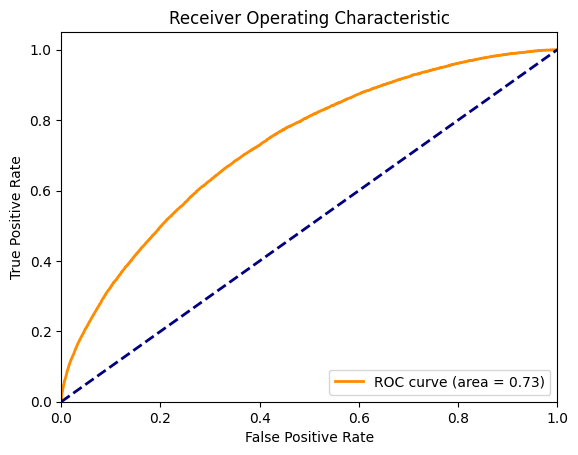

Accuracy: 0.78
3351/3351 [==============================] - 2s 462us/step - loss: 0.4602 - auc: 0.7403
Test AUC: 0.740258514881134
3351/3351 [==============================] - 1s 400us/step


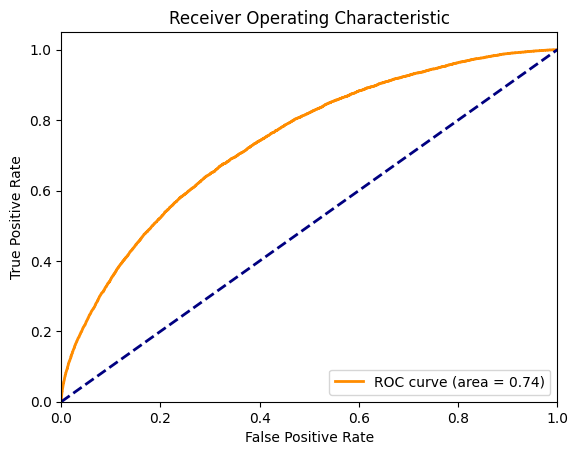

Accuracy: 0.81
2607/2607 [==============================] - 1s 470us/step - loss: 0.5073 - auc: 0.7329
Test AUC: 0.732866644859314
2607/2607 [==============================] - 1s 377us/step


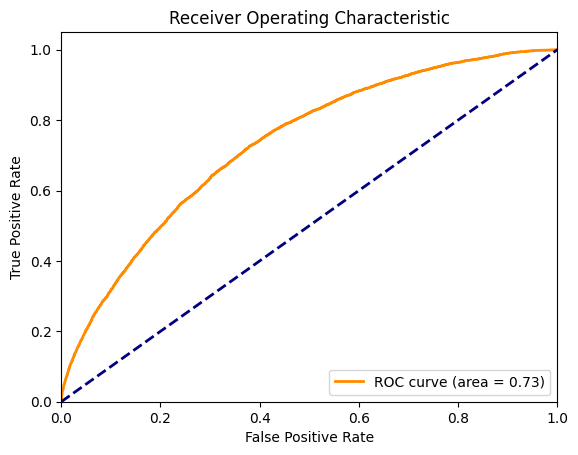

Accuracy: 0.75
17716/17716 [==============================] - 7s 411us/step - loss: 0.3976 - auc: 0.4992
Test AUC: 0.49915432929992676
17716/17716 [==============================] - 7s 368us/step


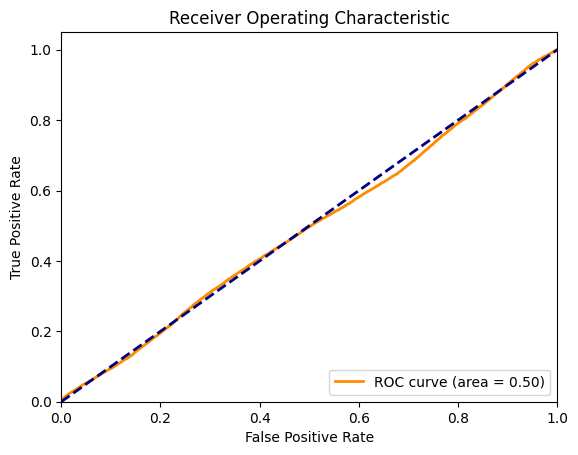

Accuracy: 0.92
9591/9591 [==============================] - 4s 437us/step - loss: 0.4086 - auc: 0.4878
Test AUC: 0.48782992362976074
9591/9591 [==============================] - 3s 356us/step


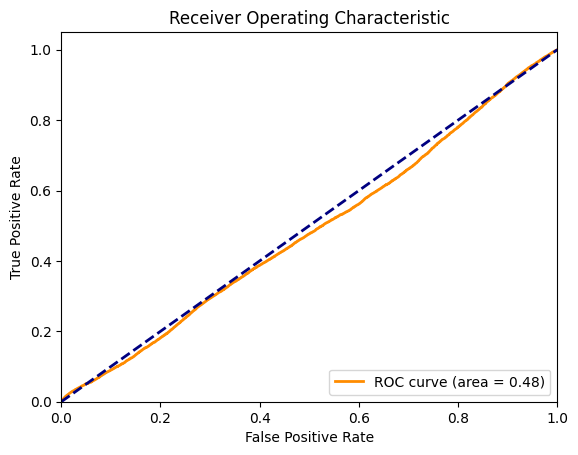

Accuracy: 0.93
8121/8121 [==============================] - 4s 452us/step - loss: 0.3868 - auc: 0.5063
Test AUC: 0.5063386559486389
8121/8121 [==============================] - 3s 378us/step


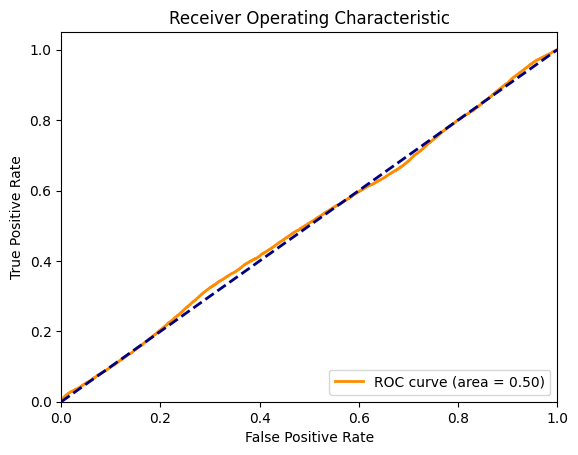

Accuracy: 0.92


/Users/pedro/Desktop/External_Validation/venv/lib/python3.8/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


107100/107127 [============================>.] - ETA: 0s - loss: 0.5628 - auc_1: 0.7547

/Users/pedro/Desktop/External_Validation/venv/lib/python3.8/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5958/5958 [==============================] - 3s 453us/step - loss: 0.3750 - auc_1: 0.6406
Test AUC: 0.6405840516090393
5958/5958 [==============================] - 2s 354us/step


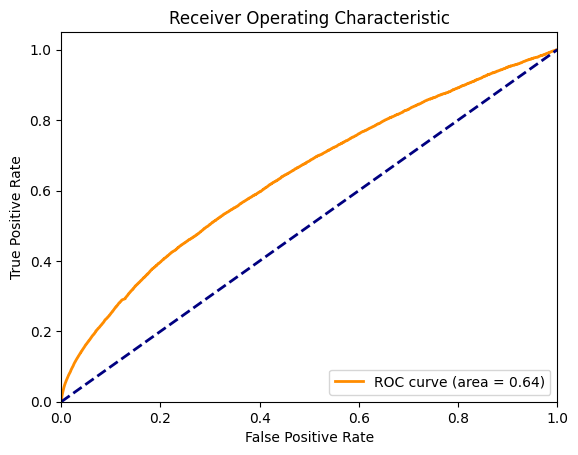

Accuracy: 0.86
3351/3351 [==============================] - 1s 439us/step - loss: 0.3708 - auc_1: 0.6461
Test AUC: 0.6460782289505005
3351/3351 [==============================] - 1s 364us/step


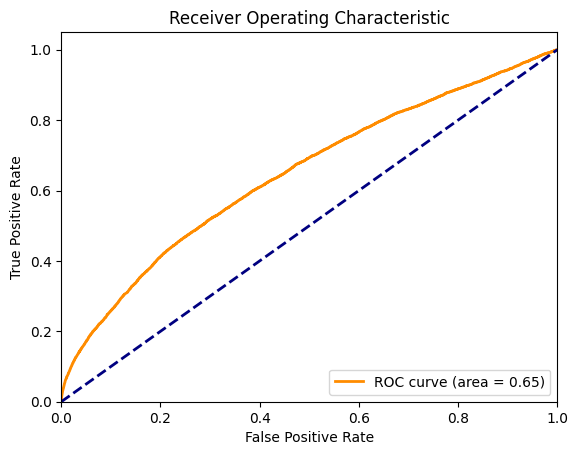

Accuracy: 0.86
2607/2607 [==============================] - 1s 476us/step - loss: 0.3802 - auc_1: 0.6318
Test AUC: 0.6318498849868774
2607/2607 [==============================] - 1s 358us/step


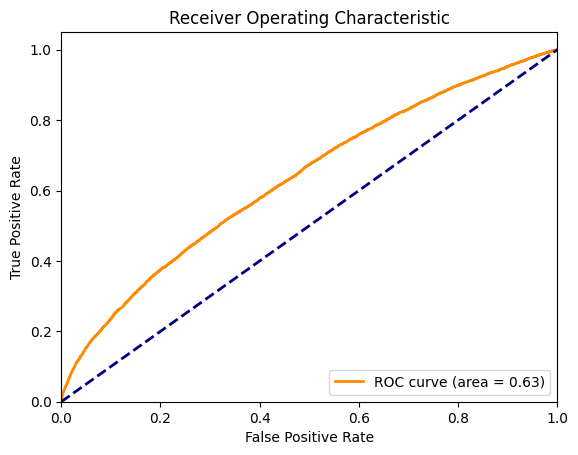

Accuracy: 0.86
17716/17716 [==============================] - 7s 420us/step - loss: 0.4332 - auc_1: 0.7596
Test AUC: 0.7595781087875366
17716/17716 [==============================] - 6s 345us/step


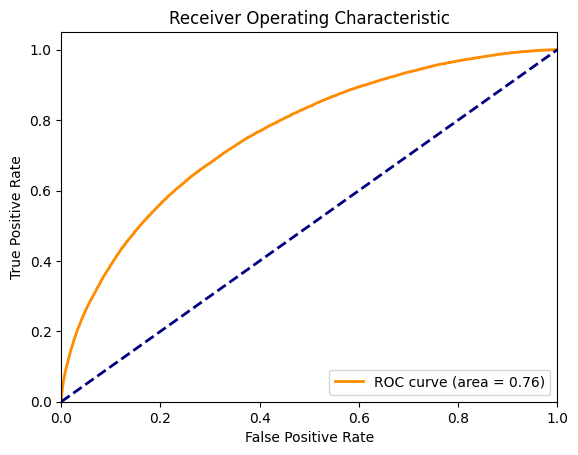

Accuracy: 0.81
9591/9591 [==============================] - 4s 425us/step - loss: 0.4358 - auc_1: 0.7654
Test AUC: 0.7654426693916321
9591/9591 [==============================] - 3s 352us/step


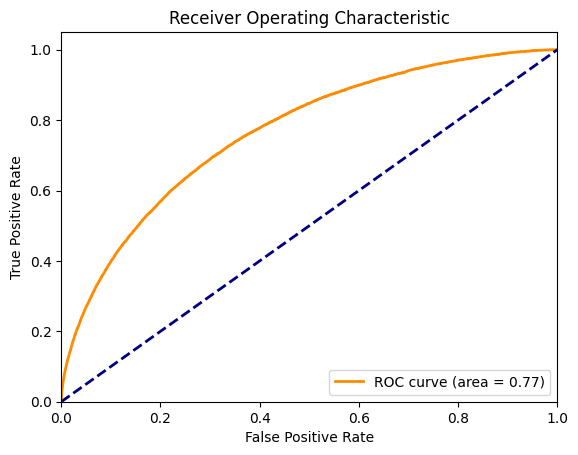

Accuracy: 0.81
8121/8121 [==============================] - 3s 420us/step - loss: 0.4270 - auc_1: 0.7643
Test AUC: 0.7642853260040283
8121/8121 [==============================] - 3s 348us/step


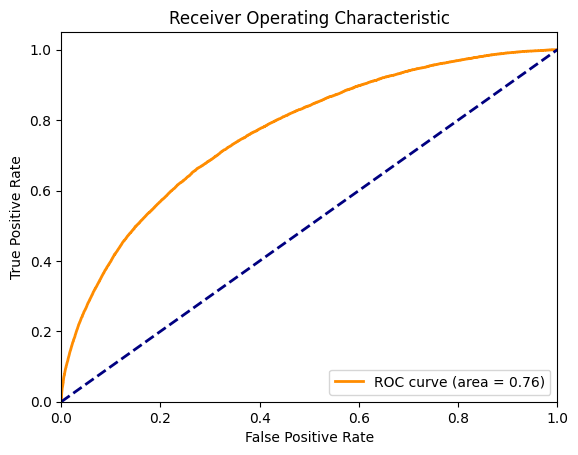

Accuracy: 0.82


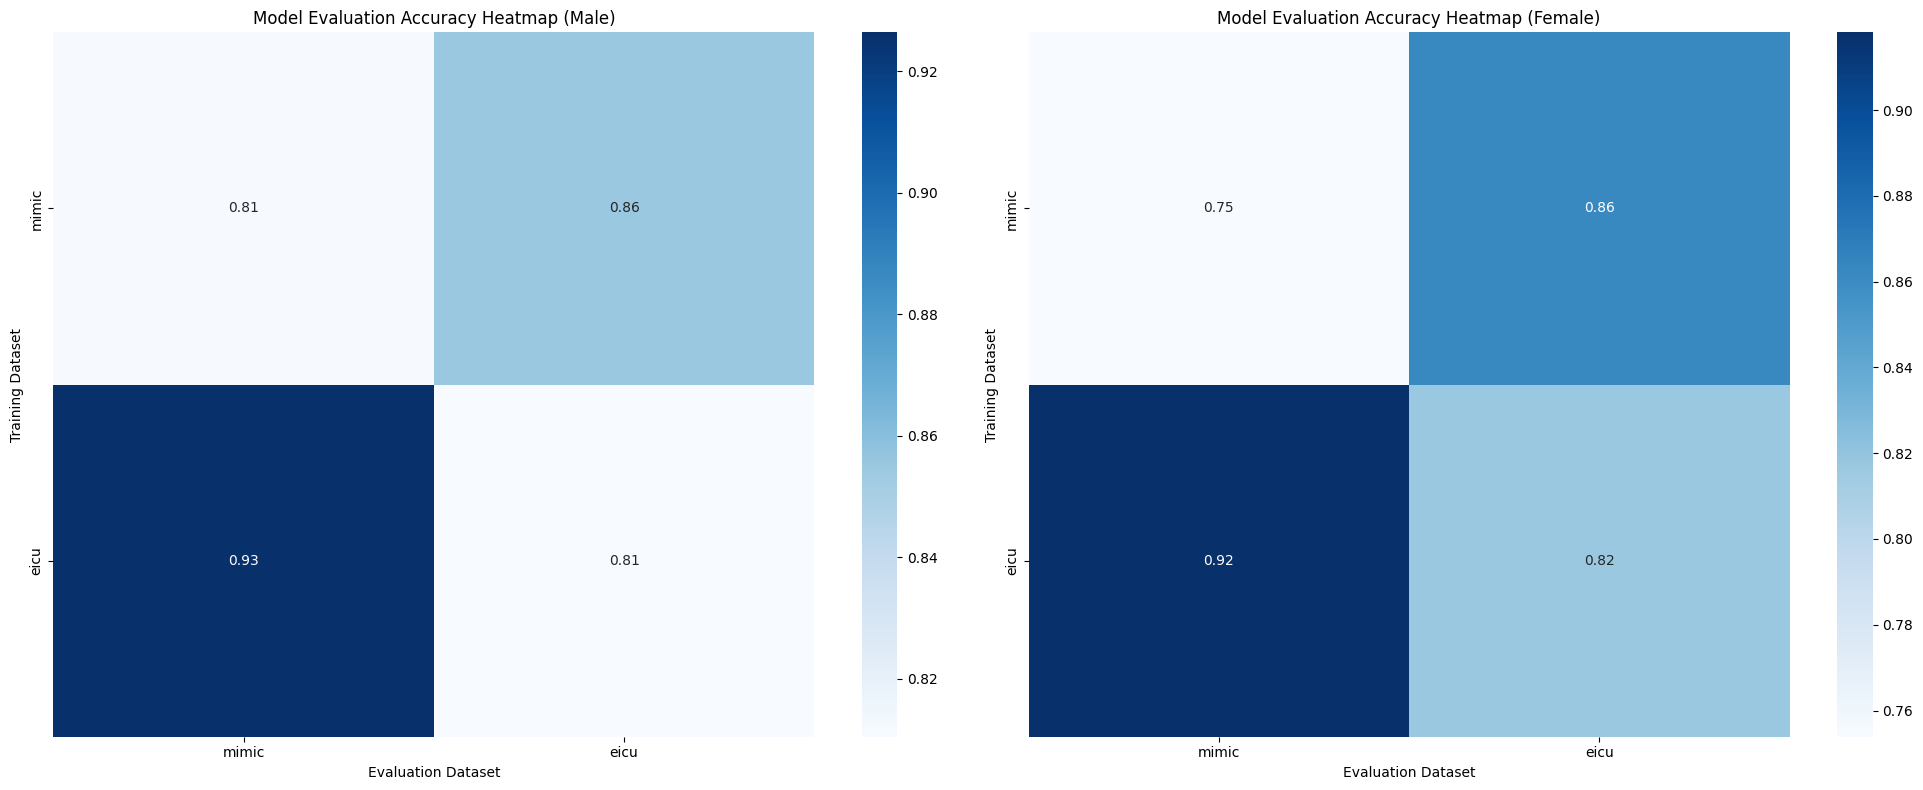

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(datasets, evaluation_datasets):
    results = {}
    male_results = {}
    female_results = {}

    for dataset in datasets:
        model, scaler = train_model(dataset)
        
        for evaluation_dataset in evaluation_datasets:
            evaluate_and_store_results(dataset, evaluation_dataset, model, scaler, results)
            evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, male_results, 'Male')
            evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, female_results, 'Female')

    return results, male_results, female_results

def evaluate_and_store_results(dataset, evaluation_dataset, model, scaler, results):
    y_pred_proba, y_test_df = test_model(evaluation_dataset, model, scaler)
    accuracy = visualize_results(y_test_df['label'], y_pred_proba)

    if dataset not in results:
        results[dataset] = {}
    results[dataset][evaluation_dataset] = accuracy

def evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, gender_results, gender):
    demographic_data = pd.read_parquet(f'../../{evaluation_dataset}/sta.parquet')
    gender_ids = filter_by_gender(demographic_data, gender)
    y_pred_proba, y_test_df = test_model(evaluation_dataset, model, scaler, stay_ids=gender_ids)
    accuracy = visualize_results(y_test_df['label'], y_pred_proba)

    if dataset not in gender_results:
        gender_results[dataset] = {}
    gender_results[dataset][evaluation_dataset] = accuracy

def create_heatmap(data, ax, title):
    sns.heatmap(data, annot=True, cmap="Blues", cbar=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Evaluation Dataset')
    ax.set_ylabel('Training Dataset')

# Assume datasets and evaluation_datasets are predefined lists of dataset names
results, male_results, female_results = train_and_evaluate(datasets, evaluation_datasets)

# Convert results to DataFrames
results_df = pd.DataFrame(results)
male_results_df = pd.DataFrame(male_results)
female_results_df = pd.DataFrame(female_results)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create heatmaps side by side
create_heatmap(male_results_df, axes[0], 'Model Evaluation Accuracy Heatmap (Male)')
create_heatmap(female_results_df, axes[1], 'Model Evaluation Accuracy Heatmap (Female)')

# Adjust layout and display the heatmaps
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(datasets, evaluation_datasets):
    results = {}
    male_results = {}
    female_results = {}
    age_0_30_results = {}
    age_30_60_results = {}
    age_60_100_results = {}

    for dataset in datasets:
        model, scaler = train_model(dataset)
        
        for evaluation_dataset in evaluation_datasets:
            evaluate_and_store_results(dataset, evaluation_dataset, model, scaler, results)
            evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, male_results, 'Male')
            evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, female_results, 'Female')
            evaluate_and_store_age_results(dataset, evaluation_dataset, model, scaler, age_0_30_results, 0, 30)
            evaluate_and_store_age_results(dataset, evaluation_dataset, model, scaler, age_30_60_results, 30, 60)
            evaluate_and_store_age_results(dataset, evaluation_dataset, model, scaler, age_60_100_results, 60, 100)

    return results, male_results, female_results, age_0_30_results, age_30_60_results, age_60_100_results

def evaluate_and_store_results(dataset, evaluation_dataset, model, scaler, results):
    y_pred_proba, y_test_df = test_model(evaluation_dataset, model, scaler)
    accuracy = visualize_results(y_test_df['label'], y_pred_proba)

    if dataset not in results:
        results[dataset] = {}
    results[dataset][evaluation_dataset] = accuracy

def evaluate_and_store_gender_results(dataset, evaluation_dataset, model, scaler, gender_results, gender):
    demographic_data = pd.read_parquet(f'../../{evaluation_dataset}/sta.parquet')
    gender_ids = filter_by_gender(demographic_data, gender)
    y_pred_proba, y_test_df = test_model(evaluation_dataset, model, scaler, stay_ids=gender_ids)
    accuracy = visualize_results(y_test_df['label'], y_pred_proba)

    if dataset not in gender_results:
        gender_results[dataset] = {}
    gender_results[dataset][evaluation_dataset] = accuracy

def evaluate_and_store_age_results(dataset, evaluation_dataset, model, scaler, age_results, min_age, max_age):
    demographic_data = pd.read_parquet(f'../../{evaluation_dataset}/sta.parquet')
    age_ids = filter_by_age(demographic_data, min_age, max_age)
    y_pred_proba, y_test_df = test_model(evaluation_dataset, model, scaler, stay_ids=age_ids)
    accuracy = visualize_results(y_test_df['label'], y_pred_proba)

    if dataset not in age_results:
        age_results[dataset] = {}
    age_results[dataset][evaluation_dataset] = accuracy

def create_heatmap(data, ax, title):
    sns.heatmap(data, annot=True, cmap="Blues", cbar=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Evaluation Dataset')
    ax.set_ylabel('Training Dataset')

# Assume datasets and evaluation_datasets are predefined lists of dataset names
results, male_results, female_results, age_0_30_results, age_30_60_results, age_60_100_results = train_and_evaluate(datasets, evaluation_datasets)

